In [20]:
import numpy as np
import pandas as pd 
import os

In [ ]:
df = pd.read_csv(r'C:\Users\warag\OneDrive\Bureau\Transfers_Rumors\data\rumors_fabrizio_romano.csv')
df.head()

,date,filename,player_value,topic,player_key,cluster,player,texte,keywords,market_value,Current_team
0,2024/09/17,kj8XZhBxvEg.json,Alvarez,Conor,Julián álvarez,0,Alvarez,Conor Conor Gallagher who already signed the c...,['Atlético Madrid Madrid'],90000000.0,Atlético de Madrid
1,2024/09/17,kj8XZhBxvEg.json,Alvarez,Madrid,Julián álvarez,1,Alvarez,Atlético Madrid Madrid Madrid and already sign...,['Atlético Madrid'],90000000.0,Atlético de Madrid
4,2024/09/15,bLx0MKdTMiA.json,Alvarez,City,Julián álvarez,1,Alvarez,"For example, just to give you some context, Ba...","['Chelsea', 'Bayer Leverkusen', 'Atlético Madr...",90000000.0,Atlético de Madrid
5,2024/08/05,n6QfN5Eh19A.json,Alvarez,Julian,Julián álvarez,1,Alvarez,"**Alvarez** is now in Europe, to advance on co...",['Manchester City'],90000000.0,Atlético de Madrid
6,2024/09/17,kj8XZhBxvEg.json,Alvarez,Madrid,Julián álvarez,2,Alvarez,Conor Conor Gallagher deal will be safe and th...,"['Atlético Madrid Madrid', 'Chelsea']",90000000.0,Atlético de Madrid


In [22]:
import spacy

nlp = spacy.load("en_core_web_trf")

def extract_orgs(text):
    if not isinstance(text, str) or text.strip() == "":
        return []
    doc = nlp(text)
    orgs = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    return list(set(orgs))  # unique org names

df['keywords'] = df['text'].apply(extract_orgs)

c:\Users\warag\AppData\Local\Programs\Python\Python311\Lib\site-packages\thinc\shims\pytorch.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

In [23]:
import numpy as np

# Replace string "nan" with actual np.nan
df['filename'] = df['filename'].replace('nan', np.nan)

# Now drop rows with NaN in that column
df = df.dropna(subset=['filename'])

In [24]:
import json

json_comment_map = {}

# Replace this path with the actual folder path of your JSON files
json_folder = r'C:\Users\warag\OneDrive\Bureau\Transfers_Rumors\video_data\result'

for filename in df['filename'].unique():
    path = os.path.join(json_folder,filename)
    try:
        with open(path, 'r', encoding='utf-8') as f:
            comments = json.load(f)  # assuming JSON is a list of comments
            json_comment_map[filename] = comments['comments']
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        json_comment_map[filename] = []



In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def build_filter_keywords(row):
    keywords = set()
    player_name = row['player'].lower()
    keywords.add(player_name)
    keywords.update(player_name.split())
    if pd.notna(row['Current_team']) and row['Current_team'].strip():
        keywords.add(row['Current_team'].lower())
    if isinstance(row['keywords'], list):
        keywords.update(k.lower() for k in row['keywords'] if isinstance(k, str))
    return keywords

def compute_player_sentiment(row):
    comments = json_comment_map.get(row['filename'], [])
    keywords = build_filter_keywords(row)
    filtered = [c for c in comments if any(kw in c.lower() for kw in keywords)]
    if not filtered:
        return 0.0
    combined_text = " ".join(filtered)
    score = analyzer.polarity_scores(combined_text)
    return score['compound']

df['sentiment'] = df.apply(compute_player_sentiment, axis=1)

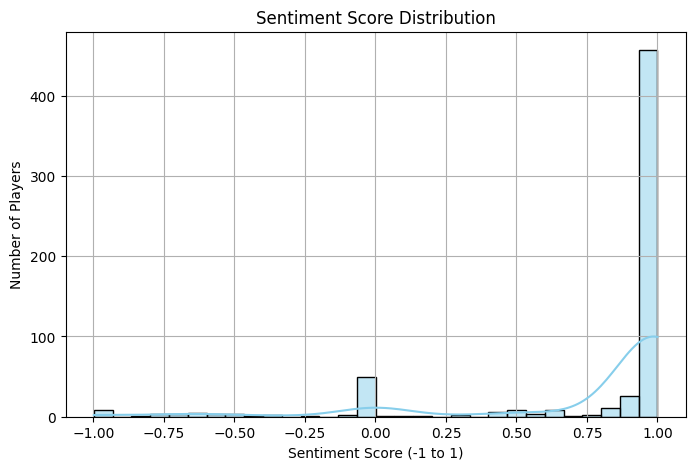

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['sentiment'], bins=30, kde=True, color='skyblue')

plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score (-1 to 1)')
plt.ylabel('Number of Players')
plt.grid(True)
plt.show()

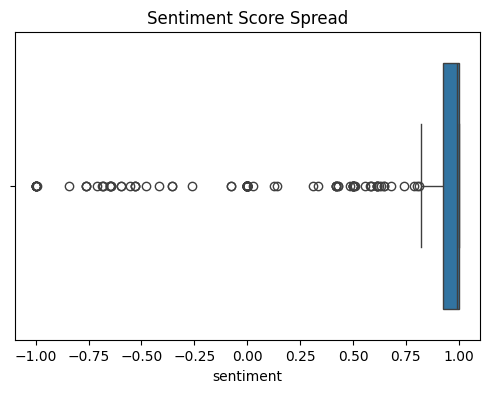

In [27]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['sentiment'])
plt.title('Sentiment Score Spread')
plt.show()

In [28]:
df.to_csv(r'C:\Users\warag\OneDrive\Bureau\Transfers_Rumors\data\rumors_fabrizio_romano.csv', index=False)